In [1]:
import torch
import torch.distributions as D
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Generate population
torch.manual_seed(0)

def generate_population():
    N = 300
    healthy_dist = D.Normal(loc=0.4, scale=0.2)
    unhealthy_dist = D.Normal(loc=0.6, scale=0.2)
    healthy = healthy_dist.sample((500,)).flatten()
    unhealthy = unhealthy_dist.sample((500,)).flatten()
    eta = torch.cat((healthy, unhealthy))
    X_dist = D.Normal(loc=eta, scale=0.05)
    X = X_dist.sample()
    alpha_dist = D.Normal(loc=0.5, scale=0.4)
    alpha = alpha_dist.sample((N,))

    arrival_time_sorted, indices = torch.sort(alpha)
    X_sort = X[indices]
    eta_sort = eta[indices]
    return arrival_time_sorted.flatten(), X_sort.flatten(), eta_sort.flatten()


def generate_hard_population():
    N = 300
    healthy_dist = D.Normal(loc=0.4, scale=0.2)
    unhealthy_dist = D.Normal(loc=0.6, scale=0.2)
    healthy = healthy_dist.sample((500,)).flatten()
    unhealthy = unhealthy_dist.sample((500,)).flatten()
    eta = torch.cat((healthy, unhealthy))
    X_dist = D.Normal(loc=eta, scale=0.05)
    X = X_dist.sample()
    alpha_dist = D.Normal(loc=eta, scale=0.05)
    alpha = alpha_dist.sample()

    arrival_time_sorted, indices = torch.sort(alpha)
    X_sort = X[indices]
    eta_sort = eta[indices]
    return arrival_time_sorted.flatten(), X_sort.flatten(), eta_sort.flatten()


In [3]:
class AllocationRule:
    def __init__(self, threshold, budget):
        self.threshold = threshold
        self.budget = budget
        
    def __call__(self, features, arrival_time):
        """
        Assume features are sorted by arrival time.
        """
        
        treatment = (features >= self.threshold) & (arrival_time <= 1)
        #set index equal to 0 if 
        for i in range(len(treatment)):
            if torch.sum(treatment[:i]) >= self.budget:
                treatment[i] = 0
        
        self.remaining_budget = self.budget - torch.sum(treatment)
        return treatment
    
class OptimalAllocationRule:
    def __init__(self, budget):
        self.budget = budget
        
    def __call__(self, X, arrival_time):
        """
        Assume eta are sorted by arrival time.
        """
        cond = (arrival_time <= 1).float()
        indices = cond.nonzero().flatten()
        X_ontime= X[indices]
        X_ontime_sort, indices_by_X = torch.sort(X_ontime, descending=True)
        
        treatment = torch.zeros(X.shape)
        used = min(self.budget, len(indices_by_X))
        self.remaining_budget = self.budget - used
        treatment[indices[indices_by_X[:used]]] = 1.
        return treatment

def get_outcomes(treatment, eta):    
    outcomes = torch.where(treatment==0, (1 - eta), treatment.float())
    return outcomes

def get_policy_utility(outcomes, remaining_budget):
    
    def c(remaining_budget):
        return - 0.5 * remaining_budget
    
    return torch.sum(outcomes) + c(remaining_budget)
        

In [4]:
def plot_threshold_vs_utility(easy=True):
    
    thresholds = torch.linspace(0, 1, 20)
    n_trials = 10
    d = []
    budget = 200
    
    for trial in range(n_trials):
        if easy:
            arrival_time_sort, X_sort, eta_sort = generate_population()
        else:
            arrival_time_sort, X_sort, eta_sort = generate_hard_population()
        
        opt_rule = OptimalAllocationRule(budget=budget)
        opt_treatment = opt_rule(X_sort, arrival_time_sort)
        opt_outcomes = get_outcomes(opt_treatment, eta_sort)
        opt_utility = get_policy_utility(opt_outcomes, opt_rule.remaining_budget)
        
        no_treatment = torch.zeros(eta_sort.shape)
        no_treatment_outcomes = get_outcomes(no_treatment, X_sort)
        no_treatment_utility = get_policy_utility(no_treatment_outcomes, budget)
        
        for threshold in thresholds:
            rule = AllocationRule(threshold=threshold, budget=budget)
            treatment = rule(X_sort, arrival_time_sort)
            outcomes = get_outcomes(treatment, eta_sort)
            utility = get_policy_utility(outcomes, rule.remaining_budget)
            
            d.append({"threshold": threshold.item(), "utility": utility.item(), 
                      "trial": trial, "opt_utility": opt_utility.item(), 
                      "no_treatment_utility": no_treatment_utility.item()})
    df = pd.DataFrame(d)
    sns.lineplot(data=df, x = "threshold", y="utility", marker="o", label="threshold decision")
    sns.lineplot(data=df, x="threshold", y="opt_utility", label="optimal decision based on X")
    sns.lineplot(data=df, x="threshold", y="no_treatment_utility", label="utility with no treatment")
    if easy:
        title_name = "Easy"
    else:
        title_name = "Hard"
    plt.title("{} Population - Utility vs. Threshold".format(title_name))
    plt.legend()
    return df


<ipython-input-3-a439e22d8cac>:29: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  indices = cond.nonzero().flatten()


,threshold,utility,trial,opt_utility,no_treatment_utility
0,0.000000,260.333679,0,275.679626,77.844254
1,0.052632,262.192200,0,275.679626,77.844254
2,0.105263,264.083954,0,275.679626,77.844254
3,0.157895,267.972015,0,275.679626,77.844254
4,0.210526,271.003662,0,275.679626,77.844254
...,...,...,...,...,...
195,0.789474,91.074814,9,277.102020,85.478439
196,0.842105,87.247711,9,277.102020,85.478439
197,0.894737,87.247711,9,277.102020,85.478439
198,0.947368,85.763763,9,277.102020,85.478439


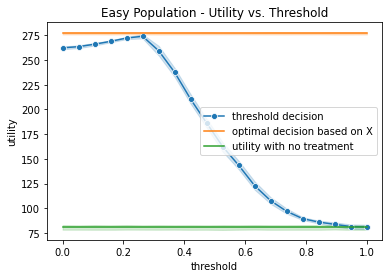

In [5]:
plot_threshold_vs_utility(easy=True)

,threshold,utility,trial,opt_utility,no_treatment_utility
0,0.000000,554.424011,0,668.821594,413.132202
1,0.052632,559.131470,0,668.821594,413.132202
2,0.105263,564.319153,0,668.821594,413.132202
3,0.157895,567.541077,0,668.821594,413.132202
4,0.210526,572.414856,0,668.821594,413.132202
...,...,...,...,...,...
195,0.789474,519.987366,9,657.087036,402.867859
196,0.842105,469.224731,9,657.087036,402.867859
197,0.894737,443.470520,9,657.087036,402.867859
198,0.947368,425.156555,9,657.087036,402.867859


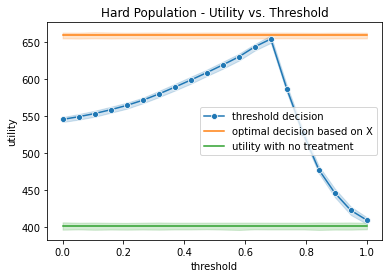

In [6]:
plot_threshold_vs_utility(easy=False)